# Retesting Julia's method for Panan005

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33399/status,
Dashboard: /proxy/33399/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40395,Workers: 28
Dashboard: /proxy/33399/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:32799,Total threads: 1
Dashboard: /proxy/35397/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:32875,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[-120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

In [6]:
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [9]:
def preprocess(ds):
    ds = ds[['so', 'volcello']].sel(yh=shelf_mask['yh'], z_l=slice(400,1000))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [10]:
saltC = cont['so']
volcC = cont['volcello']
thikC = cont['volcello']/areaC

In [11]:
saltM = melt['so']
volcM = melt['volcello']
thikM = melt['volcello']/areaM

In [12]:
salt_bot_C = saltC.weighted(thikC.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaC.fillna(0)).mean(['xh', 'yh'])
salt_bot_M = saltM.weighted(thikM.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaM.fillna(0)).mean(['xh', 'yh'])

In [13]:
salt_bot_C = salt_bot_C.load()

In [14]:
salt_bot_M = salt_bot_M.load()

In [15]:
#Saving
salt_bot_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_botshelf_time.nc')
salt_bot_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltM_botshelf_time.nc')

Text(0.5, 1.0, 'Panan005 Time Series of Salinity for shelf below 400m')

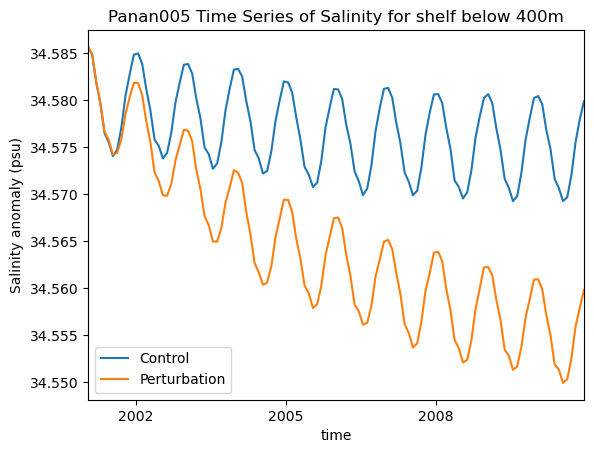

In [17]:
salt_bot_C.plot(label="Control")
salt_bot_M.plot(label="Perturbation")
plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Panan005 Time Series of Salinity for shelf below 400m")